In [1]:
import numpy as np
from scipy import signal
from PIL import Image
import matplotlib
import matplotlib.animation as animation
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pylab import *
from os.path import *
from os import listdir, makedirs
import h5py
import json
import copy
import sys
sys.path.append('../Databases/')
from database import *

In [2]:
ROOT_FOLDER = realpath('.')
Dver = 'v10'
SIM_FOLDER = 'save/'+Dver+'/Connectivity/'
databases_file = join(ROOT_FOLDER, "ElecDB2.db")
file_ = join(ROOT_FOLDER, 'whole_brain_model_Nest.h5')

In [3]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return np.float32([float(int(value[i:i + lv // 3], 16)) for i in range(0, lv, lv // 3)])

In [4]:
db = BrainDB(databases_file)
region_cond = db.getMouseBrainConds(leafs=False)
request = db.getRegions(region_cond)
id_to_region_dictionary = {}
id_to_region_dictionary_ALLNAME = {}
region_dictionary_to_id = {}
region_dictionary_to_id_ALLNAME = {}
region_dictionary_to_id_ALLNAME_parent = {}
region_dictionary_to_id_parent = {}
allname2name = {}
name2allname = {}
allnameOrder = {}
regKeys = []
region_names = []
regions_ALLNAME_list = []
is_leaf = []
glob_to_loc = {}
layers = {}

id_to_color     = {}
region_to_color = {}

iterTMP = 0
# print(request)
rows, headers = db.execute(request=request)
# print(len(rows))
i=0
for line in rows:
    id_to_region_dictionary[line[0]] = line[1]
    id_to_region_dictionary_ALLNAME[line[0]] = line[2]
    region_dictionary_to_id[line[1]] = line[0]
    region_dictionary_to_id_ALLNAME[line[2]] = line[0]

    region_dictionary_to_id_ALLNAME_parent[line[2]] = line[2].rsplit("|", 1)[1] 
    region_dictionary_to_id_parent[line[1]] = line[2].rsplit("|", 2)[1]
    allname2name [line[2]]= line[1]
    name2allname [line[1]] = line[2]
    allnameOrder [line[2]] = iterTMP; iterTMP+=1
    regKeys.append(line[0])
    region_names.append(line[1])
    regions_ALLNAME_list.append(line[2])
    is_leaf.append(line[5])
    glob_to_loc[line[0]] = i
    i+=1
    id_to_color[line[0]] = line[3]
    region_to_color[line[1]] = line[3]

    if line[2].find("Isocortex")>=0:
        if line[2].find("ayer 1")>=0:   layers[line[0]]=1
        elif line[2].find("ayer 2")>=0: layers[line[0]]=2
        elif line[2].find("ayer 3")>=0: layers[line[0]]=3
        elif line[2].find("ayer 4")>=0: layers[line[0]]=4
        elif line[2].find("ayer 5")>=0: layers[line[0]]=5
        elif line[2].find("ayer 6")>=0: layers[line[0]]=6
        else:                           layers[line[0]]=0
    else:
        layers[line[0]]=0

is_leaf = np.array(is_leaf)
filter_ = np.where(is_leaf==1)
region_names = np.array(region_names)[filter_]
regions_ALLNAME_list = np.array(regions_ALLNAME_list)[filter_]
regions_ids = np.array(regKeys)[filter_]

In [5]:
print("Loading h5 file")
conn_labels = ['AAV','KERN', 'RE']
h5file = h5py.File(file_, "r")
type_names = ["exc", "inh", "mod"]
cellTypes = np.array(h5file['neurons']['cellTypes'])
type_ID_to_name = np.array(h5file['neurons']['cellTypesToName'])
filter_ = np.zeros(cellTypes.size, dtype=bool)
for type_name in type_names:
    filter_ = np.logical_or(filter_, cellTypes==np.where(type_ID_to_name==type_name.encode('ascii'))[0])
idsNeuronsWithSyns = h5file['neurons']['default']['gid'][:]
Larea = h5file['neurons']["regions"][filter_]
isExc = h5file['neurons']["excitatory"][:]
etype   = h5file['neurons']["eTypes"][:]
ETTN    = h5file['neurons']["eTypesToName"][:].tolist()
mtype   = h5file['neurons']["neuronTypes"][:]
CTTN    = h5file['neurons']["neuronTypesToName"][:].tolist()
for i in range(len(CTTN)):
    CTTN[i]=CTTN[i].decode("ascii")
CTTN = np.array(CTTN)
for i in range(len(ETTN)):
    ETTN[i]=ETTN[i].decode("ascii")
ETTN = np.array(ETTN)
Umtype = np.unique(mtype)
Uetype = np.unique(etype)

LTN = ["Layer 1", "Layer 2", "Layer 3", "Layer 4", "Layer 5", "Layer 6"]
print("h5 file loaded")

Loading h5 file


/home/toromis/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


h5 file loaded


## Local connectivity

In [ ]:
included_regions = ["Primary somatosensory area, lower limb", 'Ventral posteromedial nucleus of the thalamus'] # Specific regions of the database targeted
regions_labels = ['SSCtx:HL', 'VPN'] 
ids_ctx = []
ids_thal = []
for id_reg in regions_ids:
    if included_regions[0] in id_to_region_dictionary_ALLNAME[id_reg] and is_leaf[glob_to_loc[id_reg]]:
        ids_ctx.append(id_reg)
    elif included_regions[1] in id_to_region_dictionary_ALLNAME[id_reg] and is_leaf[glob_to_loc[id_reg]]:
        ids_thal.append(id_reg)

In [ ]:
ids_roi = ids_ctx
roi_name = "SSCtx-HL"
if not exists(join(SIM_FOLDER, roi_name)):
    makedirs(join(SIM_FOLDER, roi_name))
translation_Lmat_to_L =  idsNeuronsWithSyns[np.in1d(Larea[idsNeuronsWithSyns], ids_roi)]
translation_Lmat_to_L = translation_Lmat_to_L[translation_Lmat_to_L!=0]
translation_L_to_Lmat = {}
maxRegNames = []
for itt,tt in enumerate(translation_Lmat_to_L): 
    translation_L_to_Lmat[tt] = itt
    maxRegNames.append( id_to_region_dictionary_ALLNAME[Larea[tt]] )
Nregs = len(translation_Lmat_to_L)
print(Nregs)
maxRegNames = np.array(maxRegNames)
uReg, counts = np.unique(maxRegNames, return_counts=True)
counts = np.cumsum(counts)
reorderingIDs = np.argsort(maxRegNames)

# Skip if already loaded
post_gids = np.array(h5file["/presyn/default/post_gid"], int)
filter_post = np.in1d(post_gids, translation_Lmat_to_L)
post_gids = post_gids[filter_post]
pre_gids = np.array(h5file["/presyn/default/pre_gid"], int)[filter_post]
filter_pre = np.in1d(pre_gids, translation_Lmat_to_L)
pre_gids = pre_gids[filter_pre]
post_gids = post_gids[filter_pre]

matNet  = np.zeros((Nregs,Nregs), np.float32)
n_synapses = len(post_gids)
print(n_synapses)
print("Loading matrix")
for i_win in range(n_synapses):   
    matNet[  translation_L_to_Lmat[ pre_gids[i_win] ], 
             translation_L_to_Lmat[ post_gids[i_win]] ] += 1.0

# matNet[ matNet <=0.0] = 1
# matNet[:,:] +=1
print(np.max(matNet))
# matNet[matNet<=0] = np.nan
# matNet  = np.log10(matNet)

In [ ]:
loc_mat_ord = np.zeros(matNet.shape)
for ii in range(matNet.shape[0]):
    for jj in range(matNet.shape[1]):
        loc_mat_ord[ii,jj] = matNet[reorderingIDs[ii],reorderingIDs[jj]]

fig = figure(figsize=(15,15)) 
imshow(loc_mat_ord, interpolation='nearest',cmap='hot')
for il in range(len(counts)-2):
    plt.axhline(y=[counts[il]], color='b', linewidth=1)    
    plt.axvline(x=[counts[il]], color='b', linewidth=1)
title("Neuron to neuron connectivity for "+ roi_name)
tight_layout()
savefig(join(SIM_FOLDER, roi_name, "neuron_to_neuron_conn.png"), dpi=400)
close(fig)

In [ ]:
loc_layers = []
for j in Larea[translation_Lmat_to_L]:
    loc_layers.append(layers[j])
loc_layers = np.array(loc_layers)

num_layer = 6
loc_mat = np.zeros((num_layer, num_layer))
for id_src in range(1, num_layer+1):
    for id_tgt in range(1, num_layer+1):
        sum_ = np.nansum(matNet[loc_layers==id_src][:,loc_layers==id_tgt])
#         sum_ /= len(np.where(loc_layers==id_src)[0]) # normalization according to src 
        loc_mat[id_src-1, id_tgt-1] = sum_
# names = np.array(names)[sorted_ids]
names = LTN
        
fig = figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(np.log10(loc_mat), interpolation='nearest')
ax.set_xlabel('Target region')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(np.array(names))
ax.set_ylabel('Source region')
ax.set_yticks(np.arange(len(names)))
ax.set_yticklabels(np.array(names))
ax.set_title('Connectivity matrix for '+ roi_name + " log10 scale")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar(im, cax=cax)
tight_layout()
savefig(join(SIM_FOLDER, roi_name, "layer_to_layer_conn.png"), dpi=400)
close(fig)

Intra connectivity for SSCtx: 1% of the neurons 1% of the connections -> 20000\*0.01 \*0.01 = 2 synapse per neuron
-> Error in the code 
Very sparse connectivity -> max 4 synapses per pair of neuron 
Connectivity rules seem to work: no connections from L1 to L6 and very few to L5
-> Does it make sense to have only 1%?

In [ ]:
names = []
loc_to_ids = []
i = 0
for id_src in ids_roi:
    region_name = id_to_region_dictionary[id_src]
    for j in LTN:
        if j.lower() in region_name:
            region_name = j[0]+j.split()[-1]
            break
    loc_conds = region_cond[:]
    loc_conds.append(Region.table.condition(column="id", included=[id_src]))
    req = db.select(columnNames=["cell_types.name"], conditions=loc_conds)
    rows, headers = db.execute(request=req)
    for row in rows:
        names.append(region_name+"_"+row[0])
        loc_to_ids.append([id_src, row[0]])
        i+=1
loc_to_ids = np.array(loc_to_ids)
print(loc_to_ids.shape)

loc_mat = np.zeros((i, i))
tot_sum = 0
for id_src in range(i):
    src = loc_to_ids[id_src]
    src_filt = (Larea[translation_Lmat_to_L]==int(src[0]))&(CTTN[mtype[translation_Lmat_to_L]]==src[1])
    locMat = matNet[src_filt]
    tot_sum+=locMat.shape[0]
    if (locMat.shape[0]>0):
        for id_tgt in range(i):
            tgt = loc_to_ids[id_tgt]
            sum_ = np.nansum(locMat[:,(Larea[translation_Lmat_to_L]==int(tgt[0]))&(CTTN[mtype[translation_Lmat_to_L]]==tgt[1])])
            loc_mat[id_src, id_tgt] = sum_ if sum_ >= 1 else np.nan

sorted_ids = np.argsort(names)
names = np.array(names)[sorted_ids]
loc_mat_ord = np.zeros(loc_mat.shape)
for ii in range(loc_mat.shape[0]):
    for jj in range(loc_mat.shape[1]):
        loc_mat_ord[ii,jj] = loc_mat[sorted_ids[ii],sorted_ids[jj]]
fig = figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(np.log10(loc_mat_ord), interpolation='nearest')
ax.set_xlabel('Target mtype')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(np.array(names))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_ylabel('Source mtype')
ax.set_yticks(np.arange(len(names)))
ax.set_yticklabels(np.array(names))
ax.set_title('Connectivity matrix for '+ roi_name + " log10 scale")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar(im, cax=cax)
tight_layout()
savefig(join(SIM_FOLDER, roi_name, "mtype_to_mtype_conn.png"), dpi=400)
close(fig)

Some cells don't have any connections within the circuit -> are they connected outside?
check impact of orientation of axons -> create cylinders
Strong connectivity between PCs -> link to number of them

In [ ]:
# reproduce Markram fig 7A
layers_mkm = {}
for k,v in layers.items():
    layers_mkm[k]=v
    if v==2 or v==3:
        layers_mkm[k]=23

loc_layers = []
for j in Larea[translation_Lmat_to_L]:
    loc_layers.append(layers_mkm[j])
loc_layers = np.array(loc_layers)

names = []
loc_to_ids = []
mtype_size = 0
locCTTN = CTTN[mtype[translation_Lmat_to_L]]
for id_src in ids_roi:
    region_name = "L"+str(layers_mkm[id_src])
    loc_conds = region_cond[:]
    loc_conds.append(Region.table.condition(column="id", included=[id_src]))
    req = db.select(columnNames=["cell_types.name"], conditions=loc_conds)
    rows, headers = db.execute(request=req)
    for row in rows:
        name = region_name+"_"+row[0] 
        if "PC" in row[0]: 
            name = region_name+"_PC"
        src_filt = (loc_layers==int(layers_mkm[id_src]))&(np.in1d(locCTTN, row[0]))
        if len(np.unique(src_filt))>1:
            if name not in names:
                names.append(name)
                loc_to_ids.append([layers_mkm[id_src], []])
                mtype_size+=1
            for j in range(len(loc_to_ids)):
                if name == names[j]:
                    loc_to_ids[j][1].append(row[0])
                    break
        
loc_to_ids = np.array(loc_to_ids)
# print(loc_to_ids)

loc_mat = np.zeros((mtype_size, mtype_size))
loc_counts = np.zeros(len(names))
for id_src in range(mtype_size):
    src = loc_to_ids[id_src]
    src_filt = (loc_layers==int(src[0]))&(np.in1d(locCTTN, src[1]))
    locMat = matNet[src_filt]
    loc_counts[id_src] = locMat.shape[0]
#     print(names[id_src], loc_counts[id_src])
    if (locMat.shape[0]>0):
        for id_tgt in range(mtype_size):
            tgt = loc_to_ids[id_tgt]
            sum_ = np.nansum(locMat[:,(loc_layers==int(tgt[0]))&(np.in1d(locCTTN, tgt[1]))])
            loc_mat[id_src, id_tgt] = float(sum_)/float(loc_counts[id_src]) if sum_ >= 1 else np.nan
            ############################# NORMALIZATION #####################################
sorted_ids = np.argsort(names)
names = np.array(names)[sorted_ids]
loc_counts = np.array(loc_counts)[sorted_ids]
loc_to_ids = np.array(loc_to_ids)[sorted_ids]
loc_mat_ord = np.zeros(loc_mat.shape)
for ii in range(loc_mat.shape[0]):
    for jj in range(loc_mat.shape[1]):
        loc_mat_ord[ii,jj] = loc_mat[sorted_ids[ii],sorted_ids[jj]]
        
filter_colors = np.zeros((len(names), 3), np.float32)
for j, i in enumerate(np.unique(list(layers_mkm.values()))):
    filter_ = np.where(loc_to_ids[:,0]==i)
    init_color = hex_to_rgb(plt.rcParams['axes.prop_cycle'].by_key()['color'][j-1])/255.
    for ifilt, filt in enumerate(filter_[0]):
        filter_colors[filt] = init_color*(0.3+0.7*(ifilt+1)/len(filter_[0]))

fig = figure(figsize=(15, 21))
ax = plt.subplot2grid((21, 15), (0,0), colspan=7, rowspan=6)
wedges, texts = ax.pie(loc_counts, colors=filter_colors)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(names, loc_counts/np.sum(loc_counts)*100.)]
ax.set_title("Cell type distribution for "+ roi_name)
ax = plt.subplot2grid((21, 15), (0,9), colspan=3, rowspan=6)
ax.axis("off")
ax.legend(wedges, labels, loc='center', ncol=2)


ax = plt.subplot2grid((21, 1), (6,0), colspan=1, rowspan=15)
im = ax.imshow(loc_mat_ord, interpolation='nearest')
ax.set_xlabel('Target mtype')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(np.array(names))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_ylabel('Source mtype')
ax.set_yticks(np.arange(len(names)))
ax.set_yticklabels(np.array(names))
ax.set_title('Connectivity matrix for '+ roi_name)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar(im, cax=cax)

tight_layout()
savefig(join(SIM_FOLDER, roi_name, "mtype_distrib.png"))
close(fig)

Normalized matrix mtype to mtype -> close to probability for an mtype to connect to another

In [ ]:
# Projection from thalamus
proj_name = "Thalamus-VPN"
loc_thal =  idsNeuronsWithSyns[np.in1d(Larea[idsNeuronsWithSyns], ids_thal)]
post_gids = np.array(h5file["/presyn/default/post_gid"], int)
post_gids = post_gids[filter_post]
pre_gids = np.array(h5file["/presyn/default/pre_gid"], int)[filter_post]

filter_pre = np.in1d(pre_gids, loc_thal)
pre_gids = pre_gids[filter_pre]
post_gids = post_gids[filter_pre]

projNet  = np.zeros(Nregs, np.float32)
n_synapses = len(post_gids)
print(n_synapses)
print("Loading matrix")
for i_win in range(n_synapses):   
    projNet[ translation_L_to_Lmat[ post_gids[i_win]] ] += 1.0


In [ ]:
proj_mat_ord = projNet[reorderingIDs]

fig = figure(figsize=(15,15))
ax = plt.subplot2grid((15, 15), (0,0), colspan=4, rowspan=15)
ax.plot(proj_mat_ord, range(Nregs))
ax.set_ylim([0, Nregs])
ax.set_ylabel("Target Neuron Id")
ax.set_xlim([0, 30])
ax.set_xlabel('Number of synapses')
for il in range(len(counts)-1):
    ax.axhline(y=[counts[il]], color='r', linewidth=1)

loc_mat = np.zeros(mtype_size)
for id_tgt in range(mtype_size):
    tgt = loc_to_ids[id_tgt]
    sum_ = np.nansum(projNet[(loc_layers==int(tgt[0]))&(np.in1d(locCTTN, tgt[1]))])
    loc_mat[id_tgt] = float(sum_)

ax = plt.subplot2grid((15, 15), (0,5), colspan=4, rowspan=15)
ax.plot(loc_mat, range(len(names)))
ax.set_ylabel('Target mtype')
ax.set_yticks(np.arange(len(names)))
ax.set_yticklabels(np.array(names))
ax.set_xlabel('Number of synapses')
title("Projections from "+ proj_name + " to " + roi_name)
tight_layout()
savefig(join(SIM_FOLDER, roi_name, "proj_"+proj_name+".png"))
close(fig)

Projections from the thalamus does not hit the right layers -> misalignment or error in the code?

In [ ]:
names = []
loc_counts = []
loc_to_ids = []
i = 0
locETTN = ETTN[etype[translation_Lmat_to_L]]
for id_src in ids_roi:
    region_name = "L"+str(layers_mkm[id_src])
    loc_conds = region_cond[:]
    loc_conds.append(Region.table.condition(column="id", included=[id_src]))
    req = db.select(columnNames=["etypes.name"], conditions=loc_conds)
    rows, headers = db.execute(request=req)
    for row in rows:
        name = region_name+"_"+row[0] 
        src_filt = (loc_layers==int(layers_mkm[id_src]))&(np.in1d(locETTN, row[0]))
        ufilt, numfilt = np.unique(src_filt, return_counts=True)
        if len(ufilt)>1:
            if name not in names:
                names.append(name)
                loc_counts.append(numfilt[1])
                loc_to_ids.append([layers_mkm[id_src]])
                i+=1

loc_to_ids = np.array(loc_to_ids)           

sorted_ids = np.argsort(names)
names = np.array(names)[sorted_ids]
loc_counts = np.array(loc_counts)[sorted_ids]
loc_to_ids = np.array(loc_to_ids)[sorted_ids]
filter_colors = np.zeros((len(names), 3), np.float32)
for j, i in enumerate(np.unique(list(layers_mkm.values()))):
    filter_ = np.where(loc_to_ids[:,0]==i)
    init_color = hex_to_rgb(plt.rcParams['axes.prop_cycle'].by_key()['color'][j-1])/255.
    for ifilt, filt in enumerate(filter_[0]):
        filter_colors[filt] = init_color*(0.3+0.7*(ifilt+1)/len(filter_[0]))

fig = figure(figsize=(15, 6))
ax = plt.subplot2grid((6, 15), (0,0), colspan=7, rowspan=6)
wedges, texts = ax.pie(loc_counts, colors=filter_colors)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(names, np.float32(loc_counts)/np.sum(loc_counts)*100.)]
ax.set_title("Etype distribution for "+ roi_name)
ax = plt.subplot2grid((6, 15), (0,9), colspan=3, rowspan=6)
ax.axis("off")
ax.legend(wedges, labels, loc='center', ncol=2)
tight_layout()
savefig(join(SIM_FOLDER, roi_name, "etype_distrib.png"))
close(fig)

# Whole Brain

In [6]:
translation_Lmat_to_L = np.unique(Larea[idsNeuronsWithSyns])
translation_Lmat_to_L = translation_Lmat_to_L[translation_Lmat_to_L!=0]
translation_L_to_Lmat = {}
for itt,tt in enumerate(translation_Lmat_to_L): 
    translation_L_to_Lmat[tt] = itt
Nregs = len(translation_Lmat_to_L)
maxRegNames = []
[maxRegNames.append( id_to_region_dictionary_ALLNAME[tL2L] ) for tL2L in translation_Lmat_to_L]
maxRegNames = np.array(maxRegNames)
reorderingIDs = np.argsort(maxRegNames)

In [ ]:
# Skip if already loaded
pre_gids = h5file["/presyn/default/pre_gid"][:]
post_gids = h5file['presyn']['default']['post_gid'][:]
conn_types = h5file['presyn']['default']['conn_type'][:]
matNet  = np.zeros((Nregs,Nregs), np.float32)
matNetAAV  = np.zeros((Nregs,Nregs), np.float32)
matNetKERN  = np.zeros((Nregs,Nregs), np.float32)
n_synapses = len(post_gids)
print("Loading matrix")
for i_win in range(n_synapses):
    conn_type = conn_types[i_win]
    if conn_type == 0: # AAV
        matNetAAV[  translation_L_to_Lmat[ Larea[pre_gids[i_win] ] ], 
             translation_L_to_Lmat[ Larea[post_gids[i_win]] ] ] += 1.0
    else:
        matNetKERN[  translation_L_to_Lmat[ Larea[pre_gids[i_win] ] ], 
             translation_L_to_Lmat[ Larea[post_gids[i_win]] ] ] += 1.0    
    matNet[  translation_L_to_Lmat[ Larea[pre_gids[i_win] ] ], 
             translation_L_to_Lmat[ Larea[post_gids[i_win]] ] ] += 1.0

np.save(SIM_FOLDER+'mat_ALL.npy', matNet)
np.save(SIM_FOLDER+'mat_AAV.npy', matNetAAV)
np.save(SIM_FOLDER+'mat_KERN.npy', matNetKERN)

In [7]:
matNet = np.load(SIM_FOLDER+'mat_ALL.npy')
matNetAAV = np.load(SIM_FOLDER+'mat_AAV.npy')
matNetKERN = np.load(SIM_FOLDER+'mat_KERN.npy')

matNet[ matNet <=0.0] = 1
matNetAAV[ matNetAAV <=0.0] = 1
matNetKERN[ matNetKERN <=0.0] = 1
matNet  = np.log10(matNet)
matNetAAV  = np.log10(matNetAAV)
matNetKERN  = np.log10(matNetKERN)

In [8]:
matNetRGB_ALL  = np.zeros((matNet.shape[0],matNet.shape[1],3), np.float32)
matNetRGB_AAV  = np.zeros((matNet.shape[0],matNet.shape[1],3), np.float32)
matNetRGB_KERN = np.zeros((matNet.shape[0],matNet.shape[1],3), np.float32)
print("Loading color matrix")
for ll in translation_L_to_Lmat.keys():
    clrTMP = hex_to_rgb(region_to_color[id_to_region_dictionary[ll]])/255.0
    idFROM = translation_L_to_Lmat[ll]
    for iRGB in range(3):
        matNetRGB_ALL[ idFROM,:,iRGB] = matNet[ idFROM,:]*clrTMP[iRGB]
        matNetRGB_AAV[ idFROM,:,iRGB] = matNetAAV[ idFROM,:]*clrTMP[iRGB]
        matNetRGB_KERN[ idFROM,:,iRGB] = matNetKERN[ idFROM,:]*clrTMP[iRGB]

Loading color matrix


In [9]:
matNetRGB_reordered_ALL  = np.zeros((matNet.shape[0],matNet.shape[1],3), np.float32)
matNetRGB_reordered_AAV  = np.zeros((matNet.shape[0],matNet.shape[1],3), np.float32)
matNetRGB_reordered_KERN = np.zeros((matNet.shape[0],matNet.shape[1],3), np.float32)
for ii in range(matNet.shape[0]):
    for jj in range(matNet.shape[1]):
        matNetRGB_reordered_ALL[ii,jj,:]  = matNetRGB_ALL[reorderingIDs[ii],reorderingIDs[jj],:]
        matNetRGB_reordered_AAV[ii,jj,:]  = matNetRGB_AAV[reorderingIDs[ii],reorderingIDs[jj],:]
        matNetRGB_reordered_KERN[ii,jj,:]  = matNetRGB_KERN[reorderingIDs[ii],reorderingIDs[jj],:]
matNetRGB_reordered_ALL/=np.max(matNetRGB_reordered_ALL )
matNetRGB_reordered_ALL= (matNetRGB_reordered_ALL*255).astype('uint8')
matNetRGB_reordered_AAV/=np.max(matNetRGB_reordered_AAV )
matNetRGB_reordered_AAV=(matNetRGB_reordered_AAV*255).astype('uint8')
matNetRGB_reordered_KERN/=np.max(matNetRGB_reordered_KERN )
matNetRGB_reordered_KERN=(matNetRGB_reordered_KERN*255).astype('uint8')

In [10]:
Image.fromarray(matNetRGB_reordered_ALL).save(SIM_FOLDER + 'mat_ALL.png', "PNG")
Image.fromarray(matNetRGB_reordered_AAV).save(SIM_FOLDER + 'mat_AAV.png', "PNG")
Image.fromarray(matNetRGB_reordered_KERN).save(SIM_FOLDER + 'mat_KERN.png', "PNG")

/home/toromis/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in float_scalars
  after removing the cwd from sys.path.
/home/toromis/.local/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


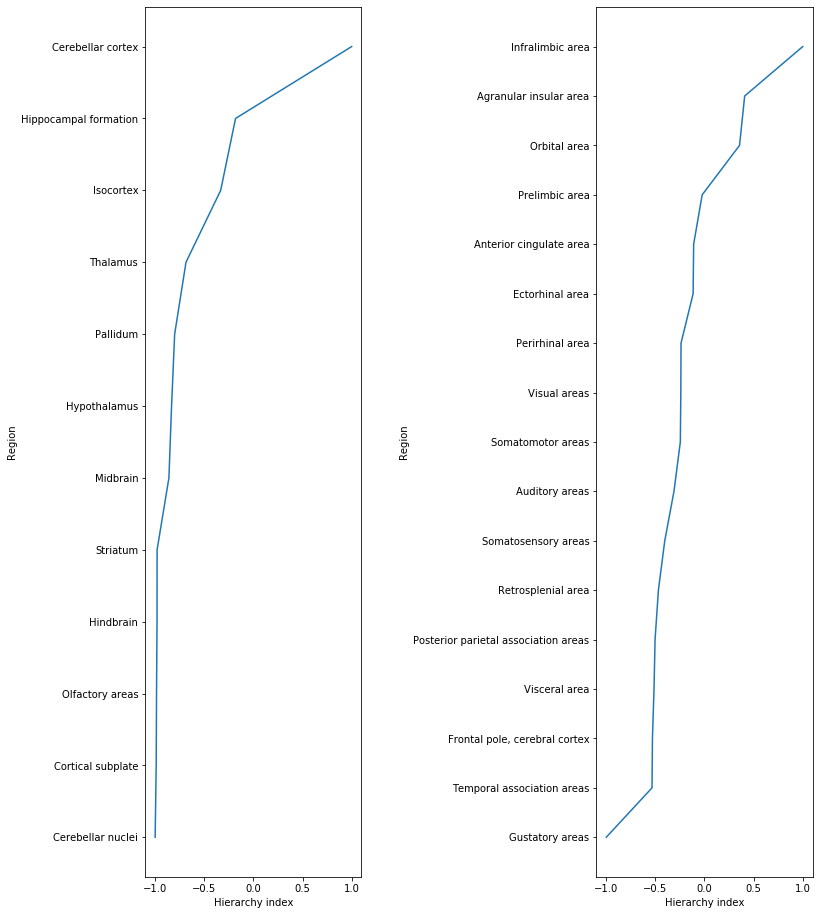

In [11]:
projRatios = np.ones(matNet.shape[0])
projRatiosAAV = np.ones(matNetAAV.shape[0])
for ii in range(matNet.shape[0]):
    projRatios[ii] = np.sum(matNet[:,ii])/np.sum(matNet[ii,:])
    denom = np.sum(matNetAAV[ii,:])
    denom = denom if denom>0 else 1.
    projRatiosAAV[ii] = np.sum(matNetAAV[:,ii]) / denom

loc_conds = region_cond[:]
loc_conds.append(Region.table.condition(column="parent", included=[region_dictionary_to_id["Isocortex"]]))
req = db.select(columnNames=["regions.id"], conditions=loc_conds)
sub_reg_ctx, headers = db.execute(request=req)
sub_reg_ctx = np.array(sub_reg_ctx)[:,0]

ids_ctx = []
ids_loc = []
grouping_regions = {
    "Isocortex":[], 
    "Olfactory areas":[], "Hippocampal formation":[], "Cortical subplate":[], "Striatum":[], "Pallidum":[],"Thalamus":[], "Hypothalamus":[], "Midbrain":[], "Hindbrain":[], "Cerebellar cortex":[], "Cerebellar nuclei":[]}

for ii, id_reg in enumerate(translation_Lmat_to_L):
    allname = id_to_region_dictionary_ALLNAME[id_reg]
    if "Isocortex" in allname:
        ids_ctx.append(ii)
        for jj, subCtx in enumerate(sub_reg_ctx):
            if id_to_region_dictionary_ALLNAME[subCtx] in id_to_region_dictionary_ALLNAME[id_reg]:
                ids_loc.append(jj)
                break
    for jj in grouping_regions.keys():
        if jj in allname:
            grouping_regions[jj].append(ii)
            break
ids_loc = np.array(ids_loc)

names = list(grouping_regions.keys())
meanRatios = np.zeros(len(names))

for ii, reg in enumerate(names):
    meanRatios[ii] = np.mean(projRatiosAAV[grouping_regions[reg]])
#     meanRatios[ii] = np.mean(projRatios[grouping_regions[reg]])
meanRatios=meanRatios-np.min(meanRatios)
meanRatios=meanRatios*2/np.max(meanRatios)-1
reorderingIDs = np.argsort(meanRatios)
names = np.array(names)[reorderingIDs]
meanRatios = meanRatios[reorderingIDs]

fig = figure(figsize=(16,16))
ax = plt.subplot2grid((16, 16), (0,4), colspan=4, rowspan=16)
ax.plot(meanRatios, range(len(names)))
ax.set_ylabel('Region')
ax.set_yticks(np.arange(len(names)))
ax.set_yticklabels(np.array(names))
ax.set_xlabel('Hierarchy index')

projRatios = projRatios[ids_ctx]
meanRatios = np.zeros(len(sub_reg_ctx))
names = []
for ii in range(len(sub_reg_ctx)):
    meanRatios[ii] = np.mean(projRatios[ids_loc==ii])
    names.append(id_to_region_dictionary[sub_reg_ctx[ii]])
meanRatios=meanRatios-np.min(meanRatios)
meanRatios=meanRatios*2/np.max(meanRatios)-1
reorderingIDs = np.argsort(meanRatios)
names = np.array(names)[reorderingIDs]
meanRatios = meanRatios[reorderingIDs]

ax = plt.subplot2grid((16, 16), (0,12), colspan=4, rowspan=16)
ax.plot(meanRatios, range(len(names)))
ax.set_ylabel('Region')
ax.set_yticks(np.arange(len(names)))
ax.set_yticklabels(np.array(names))
ax.set_xlabel('Hierarchy index')
tight_layout()
savefig(join(SIM_FOLDER, "hierarchy.png"))

Hierarchy of the Isocortex regions depending on their in/out degree ratio -> does not make a lot of sense, might be link to the number of neurons?

/home/toromis/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


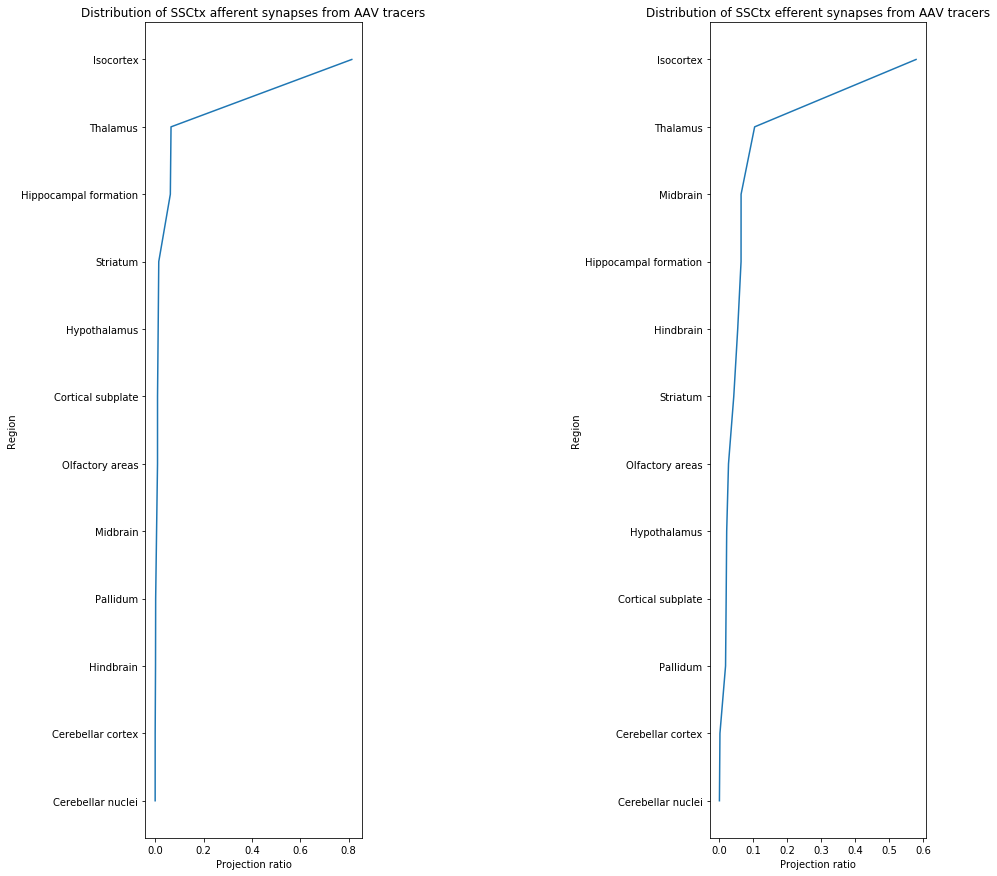

In [12]:
ids_ctx = []
names = list(grouping_regions.keys())

for ii, id_reg in enumerate(translation_Lmat_to_L):
    if "Primary somatosensory area" in id_to_region_dictionary_ALLNAME[id_reg]:
        ids_ctx.append(ii)

projNet = np.zeros(len(names))
receiveNet = np.zeros(len(names))
for ii, reg in enumerate(names):
    projNet[ii] = np.sum(matNetAAV[ids_ctx][:, grouping_regions[reg]])/np.sum(matNetAAV[ids_ctx])
    receiveNet[ii] = np.sum(matNetAAV[grouping_regions[reg]][:, ids_ctx])/np.sum(matNetAAV[:, ids_ctx])
    

fig = figure(figsize=(15,15))
ax = plt.subplot2grid((15, 15), (0,0), colspan=4, rowspan=15)
reorderingIDs = np.argsort(receiveNet)
ordered_names = np.array(names)[reorderingIDs]
receiveNet = receiveNet[reorderingIDs]
ax.plot(receiveNet, range(len(names)))
ax.set_ylabel('Region')
ax.set_yticks(np.arange(len(names)))
ax.set_yticklabels(np.array(ordered_names))
ax.set_xlabel('Projection ratio')
ax.set_title('Distribution of SSCtx afferent synapses from AAV tracers')
ax = plt.subplot2grid((15, 15), (0,10), colspan=4, rowspan=15)
reorderingIDs = np.argsort(projNet)
ordered_names = np.array(names)[reorderingIDs]
projNet = projNet[reorderingIDs]
ax.plot(projNet, range(len(names)))
ax.set_ylabel('Region')
ax.set_yticks(np.arange(len(names)))
ax.set_yticklabels(np.array(ordered_names))
ax.set_xlabel('Projection ratio')
ax.set_title('Distribution of SSCtx efferent synapses from AAV tracers')
tight_layout()
savefig(join(SIM_FOLDER, "SSCTx_degrees.png"))